# Manuscript Figures

This notebook contains all necessary functions to reproduce figures in the manuscript. 

## Table of contents
- [Notes and some preparations](#1)
- [Fig. 2](#2)
- [Fig. 3](#3)
- [Fig. 4](#4)
- [Fig. 5](#5)
- code for Fig. 6 is included in a separate notebook, `demo phenol alkylation.ipynb`

## Notes and some preparations <a name="1"></a>

We do show the functions that generated these log files as well, but they will take some time to run and will likely be slightly different from run to run due to randomness. 

For these reasons, we saved the simulation results as log files, and all analyses are made with these saved log files to ensure exact reproduction of the figures. Log files can be found in the `manuscript figures/saved logs/` folder.

More simulation functions can be found in `chem_simulate.py`, and more analysis functions (e.g., for figures in the SI) can be found in `chem_analyze.py`

In [25]:
# bandit imports 
import utils 
import algos_regret  # Implemented bandit algorithms (that minimize regret)
from chem_arms import (simulate_propose_and_update, 
                       simulate_propose_and_update_interpolation)
from chem_analyze import (get_accuracy_bandit_algos, 
                          get_accuracy_random_exploration, 
                          plot_accuracy_best_arm, 
                          plot_accuracy_best_arm_scope_expansion)

# other library imports
import pickle
import math
import pathlib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy
from tqdm.autonotebook import tqdm
import random
import itertools
import yaml
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # change dpi for higher res display in notebook

In [2]:
log_dir = './manuscript figures/notebook logs/'  # if you simulate from this notebook, logs are saved here

## Fig. 2 <a name="2"></a>

### Nickel borylation dataset

Simulate Bayes UCB (beta prior) and Random exploration on the nickel borylation dataset first.

In [ ]:
def nickel_borylation_simulate():
    
    # fetch ground truth data and process
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/nib-etoh.csv', index_col=0)

    ground_truth['yield'] = ground_truth['yield'].apply(utils.cutoffer, args=(50,))
    ligands = ground_truth['ligand_name'].unique()
    electrophiles = ground_truth['electrophile_id'].unique()

    #######################################################################################################################
    # changable parameters
    scope_dict = {'electrophile_id': electrophiles,
                  'ligand_name': ligands,}  # entire reaction scope
    arms_dict = {'ligand_name': ligands}  # conditions
    algos = [algos_regret.BayesUCBBetaPPF(len(ligands)),
             algos_regret.Random(len(ligands))
             ]  
    wkdir = f'{log_dir}/nickel-borylation/'
    num_sims = 500  # 500 in paper 
    num_round = 100  # 100 in paper
    num_exp = 1
    propose_mode = 'random'
    #######################################################################################################################
    
    # simulate each algo 
    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'  # change folder name here
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode,
                                    )
    return

nickel_borylation_simulate()

<div class="alert alert-block alert-info"> <b>Note: </b> If you get a `File exists` error, delete the file first. This is by design to prevent accidental overwrite of log files. </div>

Explore-then-commit is separately simulated with a different function. For similar reasons as simulation logs, we ran simulations and saved the results as a .npy file, and that file is used for all analysis. 

In [10]:
def nickel_borylation_simulate_etc(max_sample=4, n_simulations=10000):

    """
    Functions to simulate explore-then-commit baseline

    Parameters
    ----------
    max_sample: int
        maximum number of samples for each condition. Usually (# of budget experiments) % (# of conditions). 
    n_simulations: int
        how many times explore-then-commit is simulated on the same dataset.

    Returns
    -------

    """

    # need to specifiy top conditions to know whether ETC algorithm gets it right or wrong
    top_three = ['Cy-JohnPhos', 'P(p-Anis)3', 'PPh2Cy']

    # fetch ground truth data and apply yield cutoff
    df = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/nib-etoh.csv', index_col=0)
    df['yield'] = df['yield'].apply(lambda x: 0 if x<50 else 1)
    
    # start simulating ETC 
    percentages = []  # accuracy; or percentage of simulations that ETC got it right
    avg_cumu_rewards = []
    gb = df.groupby(by=['ligand_name'])  # group by condition 
    for n_sample in tqdm(range(max_sample), desc='1st loop'):
        count = 0
        reward = 0
        for i in tqdm(range(n_simulations), desc='2nd loop', leave=False):
            sample = gb.sample(n_sample+1).groupby('ligand_name')  # sample each condition n times, groupby conditions
            sample_mean = sample.mean(numeric_only=True)
            sample_sum = sample.sum(numeric_only=True).sum().values[0]
            reward = reward+sample_sum
            maxs = sample_mean.loc[sample_mean['yield']==sample_mean['yield'].max()]
            random_one = random.choice(list(maxs.index))  # tie breaking when multiple maxes exist
            if random_one in top_three:
                count = count+1
        percentages.append(count/n_simulations)
        avg_cumu_rewards.append(reward/n_simulations)

    return percentages, avg_cumu_rewards

accuracy, _ = nickel_borylation_simulate_etc(4, 100)  # 10000 simulations in paper
accuracy

1st loop:   0%|          | 0/4 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

[0.28, 0.34, 0.42, 0.48]

The details of how our stepwise ETC baselines are established by round can be found in the SI. We need to add a 0.0% accuracy (since no accuracy will be availble before the first round of experiments are completed), and repeat each accuracy number by the number of possible conditions. 

In [13]:
accuracy = np.append(0.0, accuracy)
accuracy = np.repeat(accuracy, 23)  # 23 ligands in nickel borylation dataset
#np.save(f'{log_dir}/nickel-borylation/nickel_borylation_etc.npy', accuracy)
accuracy

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28,
       0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28,
       0.28, 0.28, 0.28, 0.28, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34,
       0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34,
       0.34, 0.34, 0.34, 0.34, 0.34, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42,
       0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42,
       0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.48, 0.48, 0.48, 0.48, 0.48,
       0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.

### Deoxyfluorination and C-N cross-coupling datasets 

Very similar to how nickel borylation are simulated. We only provide the bandit algorithms simulation functions for the two datasets, as the ETC simulation functions are the same as above (just need to change the dataset locations, and condition names)

In [ ]:
def deoxyfluorination_simulate():
    
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/deoxyf.csv')

    ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
    ground_truth = ground_truth[['base_name',
                                 'fluoride_name',
                                 'substrate_name',
                                 'yield']]
    bases = ground_truth['base_name'].unique()
    fluorides = ground_truth['fluoride_name'].unique()
    substrates = ground_truth['substrate_name'].unique()

    # changable parameters
    scope_dict = {'base_name': bases,
                  'fluoride_name': fluorides,
                  'substrate_name': substrates}
    arms_dict = {'base_name': bases,
                 'fluoride_name': fluorides}
    algos = [algos_regret.BayesUCBGaussian(len(bases)*len(fluorides)), 
             algos_regret.Random(len(ligands))]
    wkdir = f'{log_dir}/deoxyfluorination/'
    num_sims = 500
    num_round = 100
    num_exp = 1
    propose_mode = 'random'

    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    p = pathlib.Path(dir_name)
    p.mkdir(parents=True)
    
    for algo in algos:
        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode)
    return None


def cn_maldi_simulate():

    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/maldi-bromide.csv')
    eic_max = ground_truth['EIC(+)[M+H] Product Area'].max()
    ground_truth['yield'] = ground_truth['EIC(+)[M+H] Product Area'] / eic_max  # "yield"
    ground_truth = ground_truth[['substrate_id',
                                 'condition',
                                 'yield',]]
    conditions = ground_truth['condition'].unique()
    substrates = ground_truth['substrate_id'].unique()

    # changable parameters
    scope_dict = {'condition': conditions,
                  'substrate_id': substrates}
    arms_dict = {'condition': conditions}
    n_arms = len(conditions)
    algos = [algos_regret.BayesUCBGaussian(n_arms),
             algos_regret.Random(n_arms)]
    wkdir = f'{log_dir}/cn_maldi/bromide/'
    num_sims = 500
    num_round = 100
    num_exp = 1
    propose_mode = 'random'
    
    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode)
    return None

### Fig. 2b

As previously mentioned, we have saved the results from our simulation runs. These log files are directly used for analysis. 

One other thing to note is that we need to supply the indices of the top-n conditions. These can be identified from the `arms.pkl` file generated during simulation. For example:

In [15]:
import pickle 

with open('./manuscript figures/saved logs/nickel_borylation_bayes_ucb_beta/arms.pkl', 'rb') as f:
    arms = pickle.load(f)
    
arms

{0: ('A-paPhos',),
 1: ('CX-FBu',),
 2: ('CX-PCy',),
 3: ('Cy-BippyPhos',),
 4: ('Cy-JohnPhos',),
 5: ('Cy-PhenCar-Phos',),
 6: ('Cy-vBRIDP',),
 7: ('Kwong',),
 8: ('MeO-KITPHOS',),
 9: ('MePhos',),
 10: ('PCy3 HBF4',),
 11: ('Ph-DavePhos',),
 12: ('Ph-SPhos',),
 13: ('Ph-XPhos',),
 14: ('PMe3 HBF4',),
 15: ('P(o-Anis)3',),
 16: ('P(p-Anis)3',),
 17: ('P(p-F-Ph)3',),
 18: ('PPh2Cy',),
 19: ('PPh3',),
 20: ('PPhtBu2',),
 21: ('PXy3',),
 22: ('VPhos',)}

In [36]:
def fig_2b():
    
    dir_path = 'manuscript figures/saved logs/fig2/'
    
    # get_accuracy_bandit_algos calculates the accuracies from simulation logs and provided best_arm_indexes
    # see chem_analyze.py for more details on this function
    nib = get_accuracy_bandit_algos(
        f'{dir_path}/nickel_borylation_bayes_ucb_beta/log.csv', best_arm_indexes=[4, 16, 18])
    deoxyf = get_accuracy_bandit_algos(
        f'{dir_path}/deoxyfluorination_bayes_ucb_gaussian/log.csv', best_arm_indexes=[14, 19])
    maldi = get_accuracy_bandit_algos(
        f'{dir_path}/cn_maldi_bayes_ucb_gaussian/log.csv', best_arm_indexes=[0])
    maldi = np.insert(maldi[1:], [0], [0])  # gets rid of exploration artifact (first experiment is always Cu due to how exploration is implemented)

    nib_etc_baseline = np.load(f'{dir_path}/nickel_borylation_etc.npy')
    deoxyf_etc_baseline = np.load(f'{dir_path}/deoxyfluorination_etc.npy')
    maldi_etc_baseline = np.load(f'{dir_path}/cn_maldi_etc.npy')
    
    # get_accuracy_random_exploration calculates accuracies from random exploration
    # see chem_analyze.py for more details on this function
    nib_random_baseline = get_accuracy_random_exploration(
        f'{dir_path}/nickel_borylation_random/log.csv', best_arm_indexes=[4, 16, 18])
    deoxyf_random_baseline = get_accuracy_random_exploration(
        f'{dir_path}/deoxyfluorination_random/log.csv', best_arm_indexes=[14, 19])
    maldi_random_baseline = get_accuracy_random_exploration(
        f'{dir_path}/cn_maldi_random/log.csv', best_arm_indexes=[0])

    legends = [
        'Nickel borylation, \n top-3 accuracy, \n Bayes UCB (beta prior)',
        'Deoxyfluorination, \n top-2 accuracy, \n Bayes UCB (gaussian prior)',
        'C-N cross-coupling, \n top-1 accuracy, \n Bayes UCB (gaussian prior)'
    ]

    plt.rcParams['savefig.dpi'] = 300

    plt.plot(nib[:100], label=legends[0], color='#1f77b4', alpha=1, lw=2)
    plt.plot(nib_etc_baseline[:100], color='#1f77b4', ls='--', alpha=1, lw=2)
    plt.plot(nib_random_baseline[:100], color='#1f77b4', ls=(0, (3, 1, 1, 1, 1, 1)), alpha=1, lw=2)

    plt.plot(deoxyf[:100], label=legends[1], color='#ff7f0e', alpha=1, lw=2)
    plt.plot(deoxyf_etc_baseline[:100], color='#ff7f0e', ls='--', alpha=1, lw=2)
    plt.plot(deoxyf_random_baseline[:100], color='#ff7f0e', ls=(0, (3, 1, 1, 1, 1, 1)), alpha=1, lw=2)

    plt.plot(maldi[:100], label=legends[2], color='#2ca02c', alpha=1, lw=2)
    plt.plot(maldi_etc_baseline[:100], color='#2ca02c', ls='--', alpha=1, lw=2)
    plt.plot(maldi_random_baseline[:100], color='#2ca02c', ls=(0, (3, 1, 1, 1, 1, 1)), alpha=1, lw=2)

    plt.plot([], label='Baseline \n Explore-then-commit', ls='--', color='k')
    plt.plot([], label='Baseline \n Pure exploration', ls=(0, (3, 1, 1, 1, 1, 1)), color='k')

    plt.grid(visible=True, which='both', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left", labelspacing=1, ncols=2, columnspacing=3)
    plt.xlabel('Number of experiments')
    plt.ylabel('Top-n accuracy')
    plt.title('Accuracy of identifying top general conditions for 3 datasets')
    plt.tight_layout()
    plt.show()
    return

/var/folders/j8/j9vdlwx52872vvl9_7r57zfm0000gn/T/ipykernel_68411/171344954.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


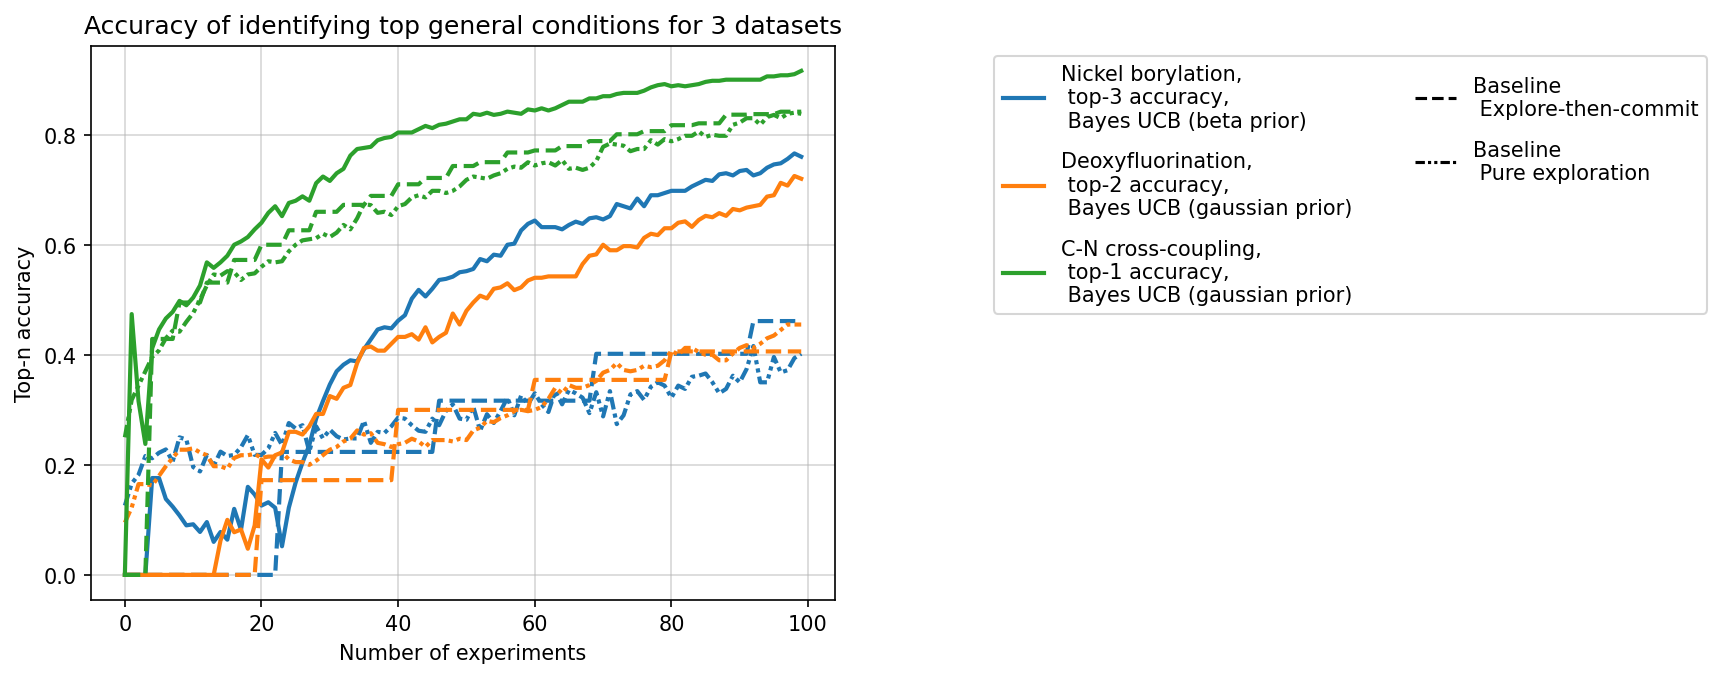

In [48]:
fig_2b()  # takes a few seconds; we usually save the calculated accuracies instead of 'get_accuracy_' every time 

## Fig. 3 <a name="3"></a>

### Fig. 3a heatmap 

In [32]:
def fig_3a():
    df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/cn-processed.csv')
    df = df[['base_name', 'ligand_name', 'substrate_id', 'additive_id', 'yield']]

    LS = df['ligand_name'].unique()
    BS = df['base_name'].unique()
    
    # calculate average by condition
    ds = []
    averages = []
    for l, b in itertools.product(LS, BS):
        tempdf = df.loc[(df['ligand_name'] == l) & (df['base_name'] == b)]
        tempdf = tempdf.drop(['ligand_name', 'base_name'], axis=1)
        a = np.array(tempdf.groupby(['substrate_id'], sort=True)['yield'].apply(list).to_list())
        # each row of a is a substrate, each column of a is an additive
        ds.append(a)
        averages.append(round(np.average(a), 2))

    data = np.vstack([np.hstack(ds[0:3]),
                      np.hstack(ds[3:6]),
                      np.hstack(ds[6:9]),
                      np.hstack(ds[9:12])])  # could've written some clever loop here, but this is way easier

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='inferno')
    text_kwargs = dict(ha='center', va='center', fontsize=15, color='white')
    ii = 0
    for i in range(4):
        for j in range(3):
            ax.add_patch(Rectangle((20 * j - 0.5, 15 * i - 0.5), 20, 15, fill=False, edgecolor='white', lw=2))
            plt.text(20 * j + 9.5, 15 * i + 7, averages[ii], **text_kwargs)
            ii = ii + 1

    #plt.axis('off')
    ax.set_xticks([9.5, 29.5, 49.5], BS, fontsize=14)
    ax.set_yticks([7, 22, 37, 52], LS, fontsize=14)
    ax.set_xlabel('Bases', fontsize=15)
    ax.set_ylabel('Ligands', fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=13)
    cbar.ax.set_ylabel('Yield (%)', rotation=270, fontsize=14, labelpad=25)
    plt.rcParams['savefig.dpi'] = 300

    plt.show()

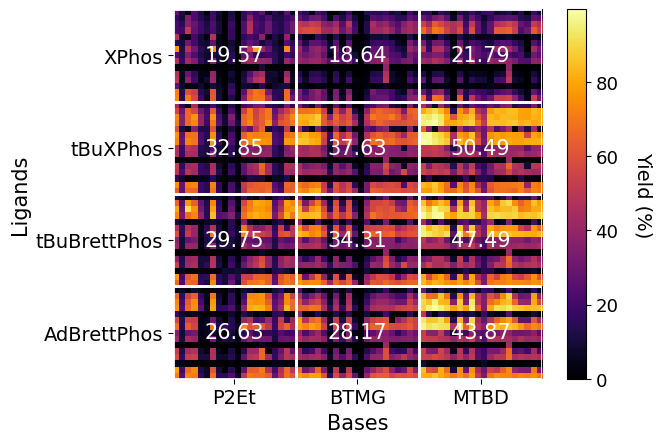

In [55]:
fig_3a()

### Simulate C-N cross-coupling dataset with bandit algorithms (for 3c)

Simulate different bandit algorithms with dataset. 

In [30]:
def cn_simulate():
    # fetch ground truth data
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/cn-processed.csv')

    ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
    ground_truth = ground_truth[['base_name',
                                 'ligand_name',
                                 'substrate_id',
                                 'additive_id',
                                 'yield']]

    bases = ground_truth['base_name'].unique()
    ligands = ground_truth['ligand_name'].unique()
    additives = ground_truth['additive_id'].unique()
    substrates = ground_truth['substrate_id'].unique()

    scope_dict = {'base_name': bases,
                  'ligand_name': ligands,
                  'additive_id': additives,
                  'substrate_id': substrates}
    arms_dict = {'base_name': bases,
                 'ligand_name': ligands}
    n_arms = len(bases)*len(ligands)
    algos = [algos_regret.UCB1Tuned(n_arms),
             algos_regret.AnnealingEpsilonGreedy(n_arms),
             algos_regret.ThompsonSamplingGaussianFixedVar(n_arms, assumed_sd=0.25),
             algos_regret.ThompsonSamplingGaussianFixedVarSquared(n_arms),
             algos_regret.BayesUCBGaussian(n_arms, assumed_sd=0.25, c=2),
             algos_regret.BayesUCBGaussianSquared(n_arms, c=2),]
    wkdir = f'{log_dir}/cn/'
    num_sims = 500
    num_round = 100
    num_exp = 1
    propose_mode = 'random'
    
    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode)
cn_simulate()

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

### Fig. 3c

Again, we are plotting with pre-saved results to exactly reproduce the figures in the paper. Explore-then-commit baseline is also directly loaded from a saved copy, which was generated in the same way as what's shown in the previous section with the nickel borylation reaction.  

In [42]:
def fig_3c(top=3):
    
    """top changes the which top-n accuracy (n=1, 2 or 3)
    """
    
    dd = 'manuscript figures/saved logs/fig3/'
    num_sims = 500  # simulation parameters, used to differentiate results w same algorithm but diff params
    num_round = 100  # by default, this is how directories are named during simulation
    num_exp = 1   # the Fig. 2 example was sanitized, with directories renamed for clarity w diff datasets
    fn_list = [f'{dd}{n}/log.csv' for n in
               [f'ts_gaussian_squared-{num_sims}s-{num_round}r-{num_exp}e',
                f'ts_gaussian_assumed_sd_0.25-{num_sims}s-{num_round}r-{num_exp}e',
                f'ucb1tuned-{num_sims}s-{num_round}r-{num_exp}e',
                f'bayes_ucb_gaussian_squared_c=2-{num_sims}s-{num_round}r-{num_exp}e',
                f'bayes_ucb_gaussian_c=2_assumed_sd=0.25-{num_sims}s-100r-{num_exp}e',
                f'eps_greedy_annealing-{num_sims}s-{num_round}r-{num_exp}e',
                ]]
    
    # Readable legend names for each algorithm
    legend_list = ['TS (implementation 1)',
                   'TS (implementation 2)',
                   'UCB1-Tuned',
                   'Bayes UCB (implementation 1)',
                   'Bayes UCB (implementation 2)',
                   'Annealing ε-greedy',]
    
    # We can make a reverse dictionary {condition_name: condition index}
    #  to directly look up arm index with names
    fp = 'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/cn-processed.csv'
    with open(f'{dd}ucb1tuned-{num_sims}s-{num_round}r-{num_exp}e/arms.pkl', 'rb') as f:
        arms_dict = pickle.load(f)

    reverse_arms_dict = {v: k for k, v in arms_dict.items()}
    if top == 3:
        conditions = [('MTBD', 'tBuXPhos'),
                      ('MTBD', 'tBuBrettPhos'),
                      ('MTBD', 'AdBrettPhos')]
    elif top == 2:
        conditions = [('MTBD', 'tBuXPhos'),
                      ('MTBD', 'tBuBrettPhos')]
    elif top == 1:
        conditions = [('MTBD', 'tBuXPhos'),]
    else:
        exit()
    indexes = [reverse_arms_dict[l] for l in conditions]
    
    # Unlike the Fig. 2 example, we do not have to extract the accuracies first
    # Because we are plotting results with the same datasets, there is a function that can directly 
    #  calculate from log.csv and plot all results. 
    # See chem_analyze.plot_accuracy_best_arm for parameter details
    plot_accuracy_best_arm(best_arm_indexes=indexes,
                           fn_list=fn_list,
                           legend_list=legend_list,
                           etc_baseline=True,
                           etc_fp=f'{dd}/etc/top{top}.npy',
                           shade_first_rounds=12,
                           title=f'',
                           xlabel='Number of experiments (time horizon)',
                           legend_title='Algorithm',
                           max_horizon_plot=96,
                           vlines=[36, 72],
                           ylabel=f'Accuracy of identifying top-{top} conditions')
    return None

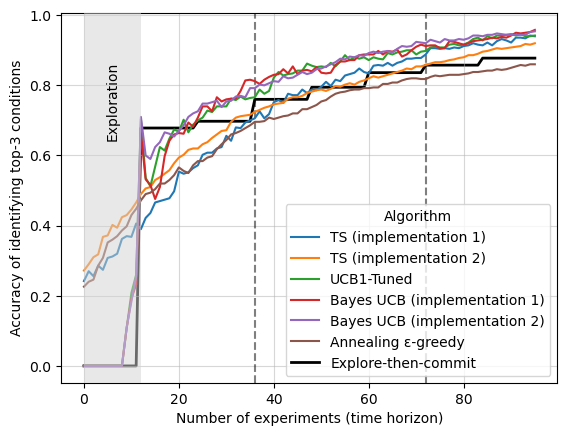

In [56]:
fig_3c()

### Fig. 3d

For the first simulation (simulation 0) of the Bayes UCB algorithm on C-N cross-coupling dataset, plot the heatmap similar to 3a, but only with the experiments selected up until a specific time point. 

In [6]:
def fig_3d(history_fp, sim=0, roun=0):
    
    """
    plots snapshots of acquisition history

    Parameters
    ----------
    history_fp: str
        file path of a history.csv generated during simulation of a bandit algorithm
    sim: int
        the index of the simulation being analyzed 
    roun: int
        plot experimental results up until this round
        ('roun' to avoid the python built-in function round)
        
    Returns
    -------

    """
    
    # load dataset
    df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/cn-processed.csv')
    df = df[['base_name', 'ligand_name', 'substrate_id', 'additive_id', 'yield']]
    LS = df['ligand_name'].unique()
    label_d = {'XPhos': 'L1', 'tBuXPhos': 'L2', 'tBuBrettPhos': 'L3', 'AdBrettPhos': 'L4'}
    labels = [label_d[l] for l in LS]
    BS = df['base_name'].unique()

    ground_truth = df[['base_name', 'ligand_name', 'substrate_id', 'additive_id']].to_numpy()

    # from acquisition history, fetch the reactions that was run, find them in ground_truth to get the indexes (to get yield later)
    history = pd.read_csv(history_fp)
    history = history.loc[(history['round'] <= roun) & (history['num_sims'] == sim)][
        ['base_name', 'ligand_name', 'substrate_id', 'additive_id']]
    history = history.to_numpy()

    # get the indexes for the experiments run, keep those yield
    # set the rest of the yields to -20 to signal no rxns run (for plotting)
    indexes = []
    for row in range(history.shape[0]):
        indexes.append(np.argwhere(np.isin(ground_truth, history[row, :]).all(axis=1))[0, 0])
    fd = df.reset_index()
    idx_to_set = fd.index.difference(indexes)
    fd.loc[idx_to_set, 'yield'] = -20

    # sort data into matrixes
    ds = []
    averages = []
    for l, b in itertools.product(LS, BS):
        # get all data
        tempdf = fd.loc[(fd['ligand_name'] == l) & (fd['base_name'] == b)]
        tempdf = tempdf.drop(['ligand_name', 'base_name'], axis=1)
        a = np.array(tempdf.groupby(['substrate_id'], sort=True)['yield'].apply(list).to_list())
        # each row of a is a substrate, each column of a is an additive
        ds.append(a)
        to_average = fd.loc[(fd['ligand_name'] == l) & (fd['base_name'] == b) & (fd['yield'] != -20)]['yield'].to_numpy()
        if len(to_average) == 0:  # catch the np.average warning for empty array
            averages.append('n/a')
        else:
            averages.append(round(np.average(to_average), 1))

    data = np.vstack([np.hstack(ds[0:3]),
                      np.hstack(ds[3:6]),
                      np.hstack(ds[6:9]),
                      np.hstack(ds[9:12])])

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='inferno', vmin=-15, vmax=105)
    text_kwargs = dict(ha='center', va='center', fontsize=15, color='white')
    ii = 0
    for i in range(4):
        for j in range(3):
            ax.add_patch(Rectangle((20 * j - 0.5, 15 * i - 0.5), 20, 15, fill=False, edgecolor='white', lw=2))
            plt.text(20 * j + 9.5, 15 * i + 7, averages[ii], **text_kwargs)
            ii = ii + 1

    #plt.axis('off')
    for i in range(1):
        for j in range(1):
            ax.set_xticks([9.5, 29.5, 49.5], BS, fontsize=14)
            ax.set_yticks([7, 22, 37, 52], labels, fontsize=14)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=13)
    cbar.ax.set_ylabel('yield (%)', rotation=270, fontsize=14, labelpad=25)
    plt.title(f'n={roun}', fontsize=14)
    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 300
    plt.show()

Fig. 3d plots n=12, 30, 60 and 99 for simulation 0. Change `roun` to desired n. 

Or change `sim` to show other simulations, see what happens...

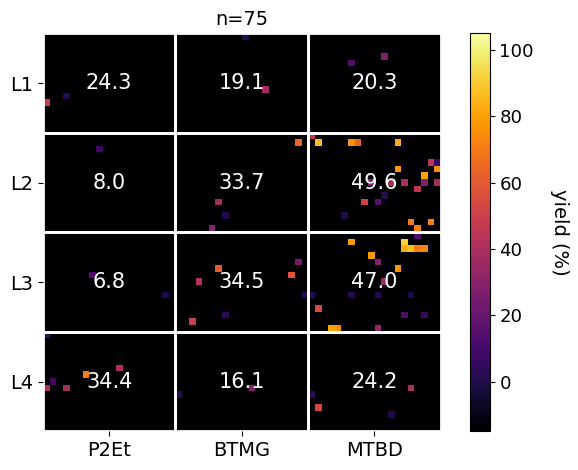

In [7]:
fig_3d(history_fp='./manuscript figures/saved logs/fig3/bayes_ucb_gaussian_c=2_assumed_sd=0.25-500s-100r-1e/history.csv',
      sim=0, 
      roun=75
      )

## Fig. 4 <a name="4"></a>

### Fig. 4a

Heatmap of all experiment results for C-H arylation dataset.

In [18]:
def fig_4a():  # heatmap for all results, grouped by ligand
    
    # load dataset
    df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/aryl-scope-ligand.csv')
    df = df[['ligand_name', 'electrophile_id', 'nucleophile_id', 'yield']]
    df['electrophile_id'] = df['electrophile_id'].apply(lambda x: x.lstrip('e')).astype('int')  # for sorting purposes, so 10 is not immediately after 1
    df['nucleophile_id'] = df['nucleophile_id'].apply(lambda x: x.lstrip('n'))
    df = df.sort_values(by=['ligand_name', 'electrophile_id', 'nucleophile_id'])
    ligand_names = list(df['ligand_name'].unique())
    nuc_names = list(df['nucleophile_id'].unique())
    elec_names = list(df['electrophile_id'].unique())

    # arrange
    # 4x6 for 24 ligands, and each ligand is represented by a 8x8 block, overall 32x48
    l = []
    averages = []

    for ligand in ligand_names:
        tempdf = df.loc[df['ligand_name'] == ligand]
        tempdf = tempdf.drop(['ligand_name'], axis=1)
        a = np.array(tempdf.groupby(['electrophile_id'], sort=True)['yield'].apply(list).to_list())
        averages.append(np.average(a))
        # each row is a electrophile, each column is a nucleophile
        l.append(a)

    a1 = np.hstack(l[0:6])
    a2 = np.hstack(l[6:12])
    a3 = np.hstack(l[12:18])
    a4 = np.hstack(l[18:24])
    a = np.vstack([a1, a2, a3, a4])

    fig, ax = plt.subplots(figsize=(9, 6))  # change figsize if texts overlap; or change text size
    text_kwargs = dict(ha='center', va='center', fontsize=10, color='white')
    text_kwargs_fs9 = dict(ha='center', va='center', fontsize=9, color='white')
    text_kwargs_fs8 = dict(ha='center', va='center', fontsize=8, color='white')  # smaller fonts for long ligand names
    text_kwargs_fs7 = dict(ha='center', va='center', fontsize=7, color='white')

    im = ax.imshow(a, cmap='inferno', vmin=0, vmax=110)
    
    # Add white borders, ligand names and average yield 
    ii = 0
    for i in range(4):
        for j in range(6):
            ax.add_patch(Rectangle((8*j-0.5, 8*i-0.5), 8, 8, fill=False, edgecolor='white', lw=2))
            if len(ligand_names[ii])<11:
                plt.text(8 * j + 3.5, 8 * i + 2.5, ligand_names[ii], **text_kwargs)
            elif len(ligand_names[ii])<13:
                plt.text(8 * j + 3.5, 8 * i + 2.5, ligand_names[ii], **text_kwargs_fs8)
            else:
                plt.text(8 * j + 3.5, 8 * i + 2.5, ligand_names[ii], **text_kwargs_fs7)
            plt.text(8 * j + 3.5, 8 * i + 4.5, str(round(averages[ii],2)), **text_kwargs)
            ii = ii+1

    ax.set_yticks(np.arange(8), labels=['1', '2', '3', '4', '5', '7', '9', '10'], fontsize=8)
    ax_t = ax.secondary_xaxis('top')
    ax_t.set_xticks(np.arange(8), labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I'], fontsize=8)
    ax.set_xticks([], [])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)

    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('Yield (%)', rotation=270)
    plt.rcParams['savefig.dpi'] = 300
    plt.show()
    return None

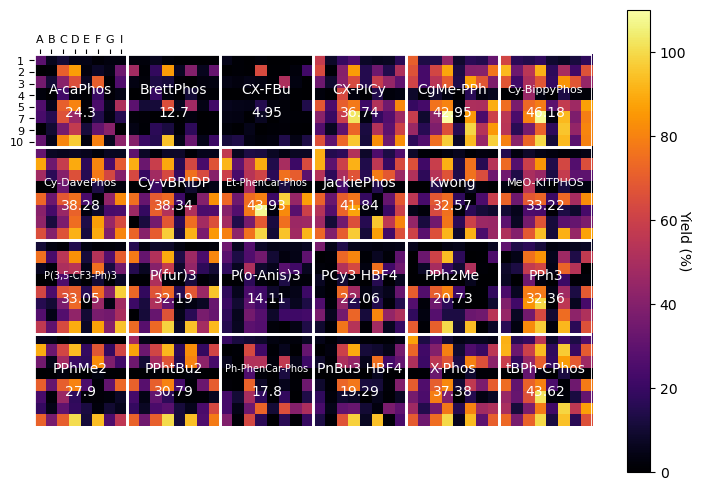

In [19]:
fig_4a()

### Fig. 4b

The optimal ligand for each substrate pairing. This represents the optimization results of a model substrate approach.

In [7]:
# To ensure each ligand has a unique color in Fig. 4, we defined a color dictionary to specify color
# (r, g, b, a) values

colors = {
    "Et-PhenCar-Phos": [0.12156862745098039, 0.47058823529411764, 0.7058823529411765, 1.0], 
    "PPh3": [0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0], 
    "PPhMe2": [0.6980392156862745, 0.8745098039215686, 0.5411764705882353, 1.0], 
    "CgMe-PPh": [0.2, 0.6274509803921569, 0.17254901960784313, 1.0],
    "JackiePhos": [0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0],
    "Cy-BippyPhos": [0.8901960784313725, 0.10196078431372549, 0.10980392156862745, 1.0],
    "PPh2Me": [0.9921568627450981, 0.7490196078431373, 0.43529411764705883, 1.0], 
    "tBPh-CPhos": [1.0, 0.4980392156862745, 0.0, 1.0], 
    "P(fur)3": [0.792156862745098, 0.6980392156862745, 0.8392156862745098, 1.0], 
    "Cy-vBRIDP": [0.984313725490196, 0.6039215686274509, 0.6, 1.0], 
    "X-Phos": [1.0, 1.0, 0.6, 1.0], 
    "P(3,5-CF3-Ph)3": [0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0]
}

In [8]:
def fig_4b(cutoff=75, preset_color_dict=None):
    """
    a heatmap, with each substrate pair as model system, highest yielding ligand is identified

    Parameters
    ----------
    cutoff: int 
        (0-100), yield cutoff. If the highest yielding ligand gives a yield lower than cutoff, it's considered not optimized
    preset_color_dict: dict
        dictionary with pre-specified ligand color {ligand_name: ligand_color}
        if None (default), use matplotlib's Paired colormap 

    Returns
    -------

    """
    
    df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/aryl-scope-ligand.csv')
    df = df[['ligand_name', 'electrophile_id', 'nucleophile_id', 'yield']]
    df['electrophile_id'] = df['electrophile_id'].apply(lambda x: x.lstrip('e')).astype('int')  # for sorting purposes, so 10 is not immediately after 1
    df['nucleophile_id'] = df['nucleophile_id'].apply(lambda x: x.lstrip('n'))
    df = df.sort_values(by=['ligand_name', 'electrophile_id', 'nucleophile_id'])
    
    fd = df.copy()
    fd['combo'] = fd['electrophile_id'].astype('str') + fd['nucleophile_id'].astype('str')
    maxes = fd.loc[fd.groupby(by=['combo'])['yield'].idxmax()]

    # assign colors for all ligands that give above cutoff yields 
    ligands_to_color = maxes.loc[maxes['yield']>cutoff]['ligand_name'].unique()

    val_to_rgb = {}  # {value: rgb}
    def color(x):
        # x: ligand name
        vals = np.arange(len(ligands_to_color)) + 1
        d = dict(zip(ligands_to_color, vals))  # {name: value}
        if x not in d:
            return 0
        else:
            if preset_color_dict is not None:
                val_to_rgb[d[x]] = preset_color_dict[x]
            return d[x]
    
    maxes['valid'] = df['yield'].apply(lambda x: 0 if x<cutoff else 1)  # 0 if highest yield < 75%
    maxes['plot'] = df['ligand_name'].apply(color)  # ligand_name to color
    maxes['plot'] = maxes['plot']*maxes['valid']  # set all substrates with best ligand yield < 75% to 0
    maxes = maxes.pivot(index='nucleophile_id', columns='electrophile_id', values='plot')
    maxes[maxes==0] = -1  # set all zeros to -1, this helps with plotting with a cmap, i can set the color for -1

    fig, ax = plt.subplots()
    if preset_color_dict is not None:
        # val_to_rgb is unordered dict, have to call one by one with a np.arange() list
        listedcolors = [val_to_rgb[ii] for ii in np.arange(len(ligands_to_color))+1]
        cmap = mpl.colors.ListedColormap(listedcolors)
    else:
        cmap = mpl.colormaps.get_cmap('Paired').copy()
    cmap.set_under('k')
    im = ax.imshow(maxes, cmap=cmap, vmin=1)

    # grid line
    for i in range(8):
        for j in range(8):
            ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='white', lw=1))

    ax.set_xticks(np.arange(8), labels=list(maxes.columns))
    ax.set_yticks(np.arange(8), labels=list(maxes.index))
    ax.set_xlabel('Electrophile (aryl bromide)')
    ax.set_ylabel('Nucleophile (imidazole)')
    
    # make legend with color patches
    values = list(np.arange(len(ligands_to_color)+1))
    ligand_color = list(ligands_to_color)
    ligand_color.insert(0, f'Not optimized (<{cutoff}%)')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=colors[i], label=ligand_color[i]) for i in range(len(values))]
    plt.legend(title='Optimal ligand', handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)

    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)

    plt.rcParams['savefig.dpi'] = 600
    plt.show()
    return None

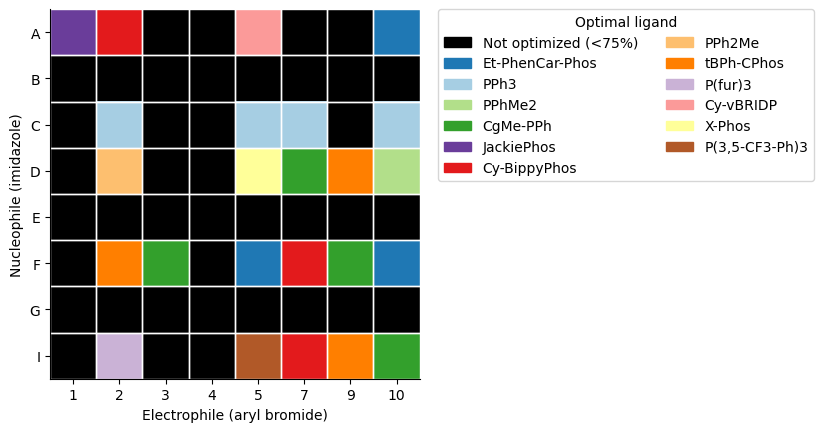

In [9]:
#fig_4b(preset_color_dict=None)
fig_4b(preset_color_dict=colors)

### Fig. 4d

In [10]:
def fig_4d(nlargest=5, preset_color_dict=None):
    """
    bar plots for ligand expansions schemes.
    Plot the average yield of the top-<nlargest> ligands before each expansion

    Parameters
    ----------
    scenario:
    nlargest: int
        decides how many top ligands are plotted
    preset_color_dict: dict
        dictionary with pre-specified ligand color {ligand_name: ligand_color}
        if None (default), use customized colors

    Returns
    -------

    """

    with open('./manuscript figures/colors.yml', 'r') as file:
        COLORS = yaml.safe_load(file)

    df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/aryl-scope-ligand.csv')
    nlist = ['nA', 'nB', 'nC', 'nD']
    elist = ['e1', 'e2', 'e3', 'e4']  # two initial lists of nucleophiles and electrophiles
    # then expand nucleophiles first, then electrophiles
    
    list_1 = df.loc[(df['nucleophile_id'].isin(nlist)) & (df['electrophile_id'].isin(elist))].groupby(['ligand_name']).mean(numeric_only=True).nlargest(nlargest, ['yield'])
    list_2 = df.loc[df['electrophile_id'].isin(elist)].groupby(['ligand_name']).mean(numeric_only=True).nlargest(nlargest, ['yield'])
    list_3 = df.groupby(['ligand_name']).mean(numeric_only=True).nlargest(nlargest, ['yield'])

    all_top_ligands = list(list_1.index) + list(list_2.index) + list(list_3.index)
    all_top_ligands = list(set(all_top_ligands))
    color_list = [COLORS['coral_essence'], COLORS['cornhusk'], COLORS['stucco'], COLORS['peach_quartz'],
                  COLORS['baby_blue'], COLORS['monument'], COLORS['provence'], COLORS['pink_tint'],
                  COLORS['classic_blue'], COLORS['lime_punch'], COLORS['pirate_black'], COLORS['jasmine_green'],
                  COLORS['red_violet']]
    colors = {}

    if preset_color_dict is not None:  # provide an color dictionary {ligand_name: color}
        color_list_count = 0  
        # this index is used in case the supplied color dict does not contain the ligand that need to be plotted
        # then colors will be incrementally selected from color_list
        for i in range(len(all_top_ligands)):
            ligand = all_top_ligands[i]
            try:
                colors[ligand] = preset_color_dict[ligand]
            except KeyError:
                colors[ligand] = 'gray'
                color_list_count += 1
    else:
        if len(all_top_ligands) > len(color_list):
            raise RuntimeError('not enough colors for all top ligands. {0} colors, {1} ligands'.format(len(color_list),
                                                                                                       len(all_top_ligands)))
        for i in range(len(all_top_ligands)):
            colors[all_top_ligands[i]] = color_list[i]

    figsize = (5,6)
    kwargs = {'aa': True, 'width': 0.5}
    plt.rcParams['savefig.dpi'] = 300
    figs, axs = plt.subplots(3, 1, figsize=figsize, constrained_layout=True)

    def trim(ll):  # trim the long ligand names
        return [s[:10] for s in ll]

    def get_colors(ll):  # for a list of names, get their color from overall color dict
        out = []
        for l in ll:
            out.append(colors[l])
        return out

    def ax_plot(ax_x, df, title, y_label=None):
        x = trim(list(df.index))
        y = list(df['yield'].values)
        axs[ax_x].bar(x, y, color=get_colors(list(df.index)), **kwargs)
        for i in range(len(x)):  # plot value
            axs[ax_x].text(i, y[i]+0.5, round(y[i], 2), ha='center')
        axs[ax_x].set_title(title)  # title
        if y_label:  # y label
            axs[ax_x].set_ylabel(y_label)
        axs[ax_x].set_ylim(top=axs[ax_x].get_ylim()[1] + 5)  # adjust ylim top so value text fits

    ax_plot(0, list_1, title='Phase I (16 products)', y_label='Yield (%)')
    ax_plot(1, list_2, title='Phase II (32 products)', y_label='Yield (%)')
    ax_plot(2, list_3, title='Phase III (64 products)', y_label='Yield (%)')

    plt.show()

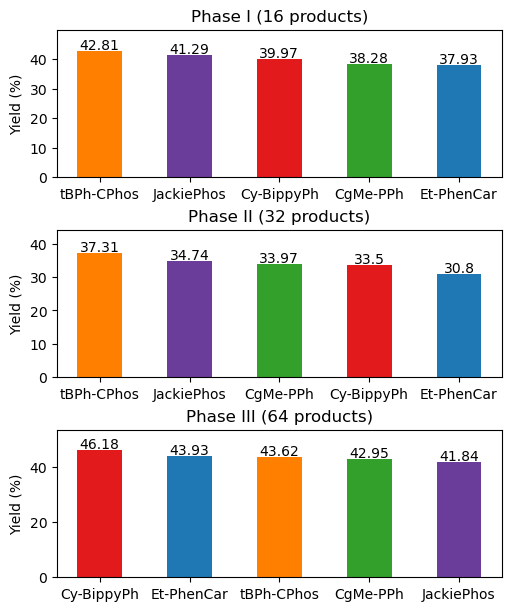

In [11]:
#fig_4d(preset_color_dict=None)
fig_4d(preset_color_dict=colors)

### Simulations with the expanding substrate scope (for Fig. 4e)

For Fig. 4e, we need to run simulations of a bandit algorithm (UCB1-Tuned) with the full scope of data, and also a scope that expands over time. 

In [4]:
def arylation_simulation_normal():
    
    # fetch ground truth data
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/aryl-scope-ligand.csv')

    ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
    ground_truth = ground_truth[['ligand_name',
                                 'electrophile_id',
                                 'nucleophile_id',
                                 'yield']]

    ligands = ground_truth['ligand_name'].unique()
    elecs = ground_truth['electrophile_id'].unique()
    nucs = ground_truth['nucleophile_id'].unique()

    scope_dict = {'ligand_name': ligands,
                  'electrophile_id': elecs,
                  'nucleophile_id': nucs}
    arms_dict = {'ligand_name': ligands}
    n_arms = len(ligands)
    algos = [algos_regret.UCB1Tuned(n_arms),]
    wkdir = f'{log_dir}/arylation/normal/'
    num_sims = 500
    num_round = 20
    num_exp = 1
    propose_mode = 'random'
    
    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, 
                                    arms_dict, 
                                    ground_truth, 
                                    algo,
                                    dir=dir_name, 
                                    num_sims=num_sims,
                                    num_round=num_round, 
                                    num_exp=num_exp, 
                                    propose_mode=propose_mode,)
    return None


def arylation_simulation_expansion():
    
    # fetch ground truth data
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/aryl-scope-ligand.csv')

    ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
    ground_truth = ground_truth[['ligand_name',
                                 'electrophile_id',
                                 'nucleophile_id',
                                 'yield']]

    ligands = ground_truth['ligand_name'].unique()
    elecs = ground_truth['electrophile_id'].unique()
    nucs = ground_truth['nucleophile_id'].unique()
    
    # starting scope
    scope_dict = {'nucleophile_id': ['nA', 'nB', 'nC', 'nD'],
                  'electrophile_id': ['e1', 'e2', 'e3', 'e4'],
                  'ligand_name': ligands}
    # expansion scope dictionary {time: {name: [labels]}}
    # e.g., at t=50, nucleophiles E,F,G,I are added to the substrate scope.
    expansion_dict = {50: {'nucleophile_id': ['nE', 'nF', 'nG', 'nI']},
                      100: {'electrophile_id': ['e5', 'e7', 'e9', 'e10']}}
    arms_dict = {'ligand_name': ligands}
    n_arms = len(ligands)
    algos = [algos_regret.UCB1Tuned(n_arms)]
    wkdir = f'{log_dir}/arylation/expansion/'
    num_sims = 500
    num_round = 200
    num_exp = 1
    propose_mode = 'random'

    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, 
                                    arms_dict, 
                                    ground_truth, 
                                    algo,
                                    dir=dir_name, 
                                    num_sims=num_sims,
                                    num_round=num_round, 
                                    num_exp=num_exp, 
                                    propose_mode=propose_mode,
                                    expansion_dict=expansion_dict)
    return None
        
# arylation_simulation_normal()
# arylation_simulation_expansion()

simulations:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

### Fig. 4e

Fig. 4e analyzes UCB1-Tuned's individual accuracies of each of the five ligands with an expanding substrate scope.

The three baselines are: 
- UCB1-Tuned top-5 accuracy
- Explore-then-commit top-5 accuracy
- Top-1 accuracy with full scope of data available

To plot all these information, we made a new `plot_accuracy_best_arm_scope_expansion()` that is based on `plot_accuracy_best_arm()`. This new function only takes 1 log file, and a list of arm indexes. It plots individual accuracies for all the provided arm indexes. To handle multiple baselines that come from different log files and analyze different arms, it takes a list of log files and a list of arm indices. For each log file, speicfied arm indices are analyzed for accuracy. 

Details about this function can be found in `chem_analyze.plot_accuracy_best_arm_scope_expansion()`.

The zoomed-in view on the right of Fig. 4e is created by running this function locally (not in notebook), and use the interactive matplotlib window.

In [12]:
def fig_4e(preset_color_dict):
    
    dd = f'./manuscript figures/saved logs/fig4/'
    log_fp = f'{dd}ucb1tuned-expansion/log.csv'
    legend_list = ['Cy-BippyPhos', 'Et-PhenCar-Phos', 'tBPh-CPhos', 'CgMe-PPh', 'JackiePhos']
    fp = 'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/aryl-scope-ligand.csv'
    with open(f'{dd}ucb1tuned-expansion/arms.pkl', 'rb') as f:
        arms_dict = pickle.load(f)

    reverse_arms_dict = {v: k for k, v in arms_dict.items()}
    top1 = ['Cy-BippyPhos']
    top5 = ['Cy-BippyPhos', 'Et-PhenCar-Phos', 'tBPh-CPhos', 'CgMe-PPh', 'JackiePhos']
    indexes = [reverse_arms_dict[(l,)] for l in top5]
    
    # for plotting the baselines with simulation results with the full scope of data
    baseline_indexes = [indexes,
                        [reverse_arms_dict[(l,)] for l in top1]
                        ]
    baseline_fps = [f'{dd}ucb1tuned-normal/log.csv',
                    f'{dd}ucb1tuned-normal/log.csv',
                    ]
    baseline_labels = ['Top-5 overall accuracy', 'Cy-BippyPhos (full scope)']
    baseline_kwargs = [
        {'color': 'k',
         'lw': 2,},
        {'color': [0.8901960784313725, 0.10196078431372549, 0.10980392156862745, 1.0],
         'alpha': 0.6,
         'ls': (0, (1, 1)),
         'lw': 2,}
    ]
    
    # use the same defined color in fig. 4
    colors = [preset_color_dict[l] for l in top5]

    plot_accuracy_best_arm_scope_expansion(arm_indexes=indexes,
                                           fp=log_fp,
                                           baseline_fps=baseline_fps,
                                           baseline_arm_indexes=baseline_indexes,
                                           baseline_labels=baseline_labels,
                                           baseline_kwargs=baseline_kwargs,
                                           legend_list=legend_list,
                                           shade_first_rounds=24,
                                           ignore_first_rounds=0,
                                           title=f'Accuracy of identifying ligand as optimal',
                                           legend_title='Ligand',
                                           max_horizon_plot=200,
                                           long_legend=True,
                                           vlines=[50, 100],
                                           preset_colors=colors,
                                           etc_baseline=True,
                                           etc_fp='dataset_logs/aryl-scope-ligand/etc/top5.npy')
    return None

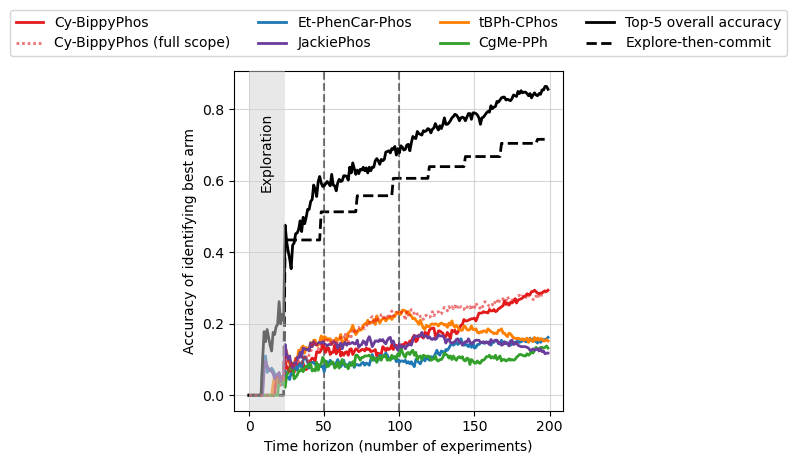

In [13]:
fig_4e(colors)

## Fig. 5 <a name="5"></a>

### Fig. 5a (heatmap of all results)

In [16]:
def fig_5a(single_component='activator'):
    """

    Parameters
    ----------
    single_component: str
        {'activator', 'solvent', 'base'}
        three components to plot here in a 2d plot; 
        <single_component> on one axis, with the other two components will be combined into one dimension

    Returns
    -------

    """

    # processing dataset
    # use shorter name for bases
    # use labels for nucleophiles
    df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/amidation.csv')

    short_name_dict = {
        '1-Methylimidazole': 'NMI',
        '2,6-Lutidine': 'lutidine',
        'N-methylmorpholine': 'NMM',
        'Diisopropylethylamine': 'DIPEA'
    }
    nuc_id_dict = dict(zip(df['nucleophile_name'].unique(), [f'n{num}' for num in np.arange(len(df['nucleophile_name'].unique()))+1]))

    df['base_name_long'] = df['base_name']
    df['base_name'] = df['base_name_long'].apply(lambda x: short_name_dict[x])
    df['nucleophile_id'] = df['nucleophile_name'].apply(lambda x: nuc_id_dict[x])

    # depending on which component is plotted on its own, group the other two and do all groupby's
    allthree = ['activator', 'base', 'solvent']
    allthree.remove(single_component)
    df['combo'] = df[f'{allthree[0]}_name'] + '/' + df[f'{allthree[1]}_name']
    df = df[['nucleophile_id', 'combo', f'{single_component}_name', 'yield']]
    df = df.sort_values(by=['nucleophile_id', 'combo', f'{single_component}_name'])
    combo_labels = df['combo'].unique()
    single_component_labels = df[f'{single_component}_name'].unique()

    gb = df.groupby(by=['nucleophile_id', 'combo'])['yield'].apply(list)
    gb2 = gb.groupby(by=['nucleophile_id']).apply(list)

    nuc_ids_list = gb2.index
    to_stack = []
    for n in nuc_ids_list[:5]:
        to_stack.append(np.array(gb2.loc[n]))
    first_five = np.hstack(to_stack)
    to_stack = []
    for n in nuc_ids_list[5:]:
        to_stack.append(np.array(gb2.loc[n]))
    second_five = np.hstack(to_stack)
    data = np.vstack((first_five, second_five))

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='inferno', vmin=0, vmax=110)
    text_kwargs = dict(ha='center', va='center', fontsize=15, color='white')
    ii = 0
    #
    for i in range(2):
        for j in range(5):
            ax.add_patch(Rectangle((len(single_component_labels) * j - 0.5, len(combo_labels) * i - 0.5),
                                   len(single_component_labels), len(combo_labels), fill=False, edgecolor='white', lw=2))
            plt.text(len(single_component_labels) * (j+0.5)-0.5, len(combo_labels) * (i+0.5)-0.5, str(nuc_ids_list[ii]), **text_kwargs)
            ii = ii + 1
            
    # # This sets labels for single_component='activator'
    # ax.set_xticks(np.arange(8), activator_labels, rotation=90)
    # ax_t = ax.secondary_xaxis('top')
    # ax_t.set_xticks(np.arange(len(single_component_labels)*5), labels=np.tile(single_component_labels, 5), rotation=90)
    # ax.set_yticks(np.arange(len(combo_labels)*2), labels=np.tile(combo_labels, 2))
    ax.set_yticks([], labels=[])
    ax.set_xticks([], labels=[])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax_t.spines['top'].set_visible(False)

    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_ylabel('yield (%)', rotation=270, fontsize=14, labelpad=25)

    plt.rcParams['savefig.dpi'] = 300

    plt.show()
    
    return None


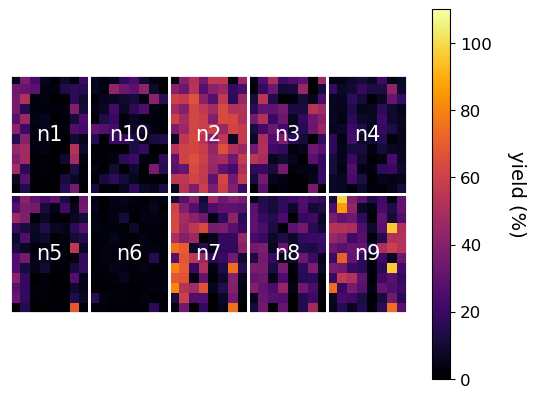

In [18]:
fig_5a('activator')

### Fig. 5c

Output and plot some prediction accuracies of the final prediction model on the entire dataset (with collected ground truth data). 

In [32]:
def fig_5c():
    """
    Accuracies of the final prediction model after the optimization of the amidation reaction
    Divided up into three groups:
    - Reactions in training data
    - Reactions with activators included in the activator/base round
    - Reactions with activators eliminated

    Returns
    -------

    """

    plt.rcParams['savefig.dpi']=600

    with open('./manuscript figures/saved logs/fig5/activator-base/cache/scope.pkl', 'rb') as f:
        s = pickle.load(f)

    pred = s.data
    pred = pred.sort_values(by=['activator_name', 'base_name', 'nucleophile_id', 'solvent_name'])
    ground_truth = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/amidation.csv')
    ground_truth = ground_truth.sort_values(by=['activator_name', 'base_name', 'nucleophile_id', 'solvent_name'])
    pred['true_yield'] = ground_truth['yield'].apply(utils.scaler).values
    # CAREFUL: need to strip index off the series above. pandas seems to sort by index when you assign series to a col

    training_data = pred.loc[pred['yield'].notna()]
    test_data = pred.loc[pred['yield'].isna()]
    eliminated_activators = test_data.loc[test_data['activator_name'].isin(['PFTU', 'HOTU', 'HATU', 'PyBOP'])]
    included_activators = test_data.loc[test_data['activator_name'].isin(['DPPCl', 'BOP-Cl', 'TCFH', 'TFFH'])]

    plt.scatter(training_data['prediction']*100, training_data['true_yield']*100, label='Reactions explored', alpha=0.7)
    plt.scatter(eliminated_activators['prediction']*100, eliminated_activators['true_yield']*100,
                label='Reactions unexplored, eliminated activators', marker='v', alpha=0.5)
    plt.scatter(included_activators['prediction']*100, included_activators['true_yield']*100,
                label='Reactions unexplored, retained activators', marker='s', alpha=0.4)
    plt.xlabel('Predicted yield (%)')
    plt.ylabel('Experimental yield (%)')
    plt.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), color='k', ls='dashed', alpha=0.5)

    print(f'training data')
    y_true = training_data['true_yield']
    y_pred = training_data['prediction']
    print(f'number of data points: {len(training_data)}')
    print(f'rmse: {math.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'mae: {mean_absolute_error(y_true, y_pred)}')
    print(f'r2: {r2_score(y_true, y_pred)}\n')

    print(f'unexplored, eliminated activators data')
    y_true = eliminated_activators['true_yield']
    y_pred = eliminated_activators['prediction']
    print(f'number of data points: {len(eliminated_activators)}')
    print(f'rmse: {math.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'mae: {mean_absolute_error(y_true, y_pred)}')
    print(f'r2: {r2_score(y_true, y_pred)}\n')

    print(f'unexplored, retained activators data')
    y_true = included_activators['true_yield']
    y_pred = included_activators['prediction']
    print(f'number of data points: {len(included_activators)}')
    print(f'rmse: {math.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'mae: {mean_absolute_error(y_true, y_pred)}')
    print(f'r2: {r2_score(y_true, y_pred)}\n')

    plt.legend()
    plt.show()
    
    return None

training data
number of data points: 120
rmse: 0.05692140914461218
mae: 0.044322508333333385
r2: 0.9284946623811835

unexplored, eliminated activators data
number of data points: 467
rmse: 0.15574051772378156
mae: 0.12050582655246252
r2: 0.20974676266919878

unexplored, retained activators data
number of data points: 373
rmse: 0.17326504991500233
mae: 0.12280822520107239
r2: 0.2569679371261976



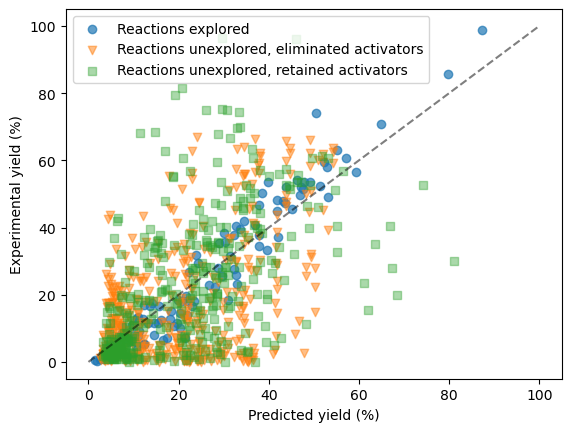

In [33]:
fig_5c()

### Fig. 5d

In [37]:
def fig_5d():
    
    # compare condition performance for each substrate, average of three solvents
    nuc_ids = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']
    #nuc_ids = ['n1', 'n3', 'n5', 'n7', 'n8', 'n9']
    df = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/amidation.csv')
    df = df.loc[df['nucleophile_id'].isin(nuc_ids)]
    df['activator-base'] = df['activator_name'] + '-' + df['base_name']
    df = df.loc[df['activator-base'].isin(['DPPCl-N-methylmorpholine', 'DPPCl-Diisopropylethylamine', 'HATU-Diisopropylethylamine', 'TCFH-1-Methylimidazole'])]
    mean = df.groupby(by=['nucleophile_id', 'activator-base'])['yield'].mean()

    plt.rcParams['savefig.dpi'] = 300
    fig, axs = plt.subplots(1, len(nuc_ids), sharex=True, figsize=(16,2), constrained_layout=True)

    short_name = {'DPPCl-N-methylmorpholine': 'DPPCl / NMM',
                  'DPPCl-Diisopropylethylamine': 'DPPCl / DIPEA',
                  'HATU-Diisopropylethylamine': 'HATU / DIPEA',
                  'TCFH-1-Methylimidazole': 'TCFH / NMI'}

    def ax_plot(ii, df, title, y_ticks=False):
        colors = ['#f26b5b', '#0f4c81', '#373838', '#a58d7f']
        labels = [short_name[l] for l in list(df.index)]
        values = list(df.values)
        pos = [2,3,1,0]
        axs[ii].barh(pos, values, height=0.5, color=colors)
        for p, v in zip(pos, values):
            axs[ii].text(v+1, p, str(round(v,1)), ha='left', va='center', c='black')
        axs[ii].set_title(title, fontweight='bold')  # title
        if y_ticks:  # y label
            axs[ii].set_yticks(pos, labels)
        else:
            axs[ii].set_yticks([])
        axs[ii].set_xlim([0,100])

    for ii, nid in zip(np.arange(len(nuc_ids)), nuc_ids):
        if nid == 'n1':
            ax_plot(ii, mean.loc[nid], title=nid, y_ticks=True)
        else:
            ax_plot(ii, mean.loc[nid], title=nid)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Average yield (%) over three solvents")
    fig.tight_layout()
    plt.tight_layout()
    plt.show()
    
    return None

/var/folders/j8/j9vdlwx52872vvl9_7r57zfm0000gn/T/ipykernel_4165/3035221692.py:45: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


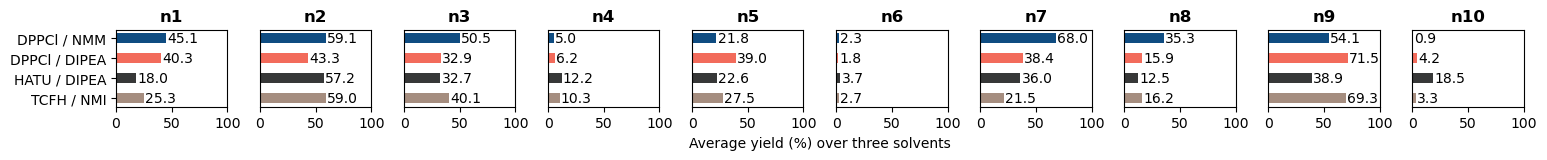

In [38]:
fig_5d()